# Imports

In [43]:
import pandas as pd
import tifffile
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

# Load in Data

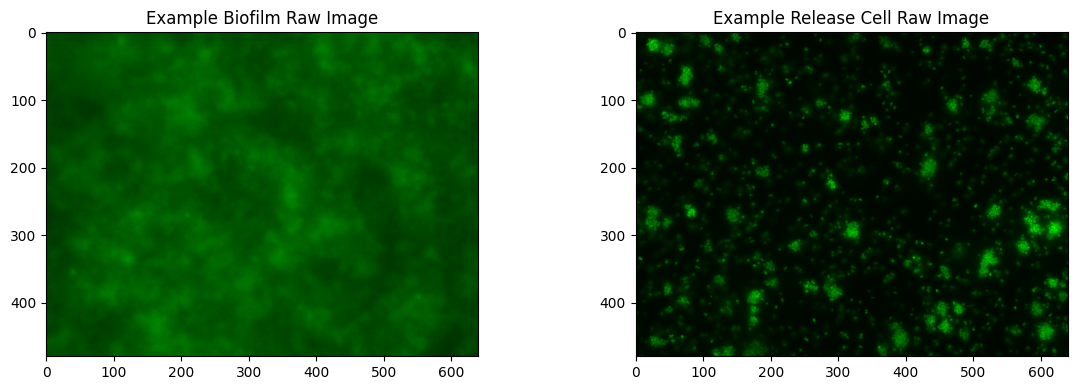

In [41]:
# Create paths to data folders
biofilm_path = 'biofilm_data/biofilm'
release_cells_path = 'biofilm_data/release_cells'

# Get all tiff files from each folder
biofilm_files = glob.glob(os.path.join(biofilm_path, '*.tif'))
release_cell_files = glob.glob(os.path.join(release_cells_path, '*.tif'))

# Load biofilm images into list
biofilm_raw_images = []
for file in biofilm_files:
    img = tifffile.imread(file)
    biofilm_raw_images.append(img)

# Load release cell images into list  
release_cell_raw_images = []
for file in release_cell_files:
    img = tifffile.imread(file)
    release_cell_raw_images.append(img)


# Display example images
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.imshow(biofilm_raw_images[0])
plt.title('Example Biofilm Raw Image')

plt.subplot(122)
plt.imshow(release_cell_raw_images[0])
plt.title('Example Release Cell Raw Image')

plt.tight_layout()
plt.show()

# Grayscale each image

### Check if there are any red or blue values in any images

In [30]:
# Check biofilm images for red and blue values
print("Summary of biofilm images:")
red_counts = sum(img[:,:,0].any() for img in biofilm_raw_images)
blue_counts = sum(img[:,:,2].any() for img in biofilm_raw_images)
print(f"Images containing red values: {red_counts} out of {len(biofilm_raw_images)}")
print(f"Images containing blue values: {blue_counts} out of {len(biofilm_raw_images)}")

print("\nSummary of release cell images:")
red_counts = sum(img[:,:,0].any() for img in release_cell_raw_images)
blue_counts = sum(img[:,:,2].any() for img in release_cell_raw_images)
print(f"Images containing red values: {red_counts} out of {len(release_cell_raw_images)}")
print(f"Images containing blue values: {blue_counts} out of {len(release_cell_raw_images)}")

Summary of biofilm images:
Images containing red values: 0 out of 6
Images containing blue values: 0 out of 6

Summary of release cell images:
Images containing red values: 0 out of 6
Images containing blue values: 0 out of 6


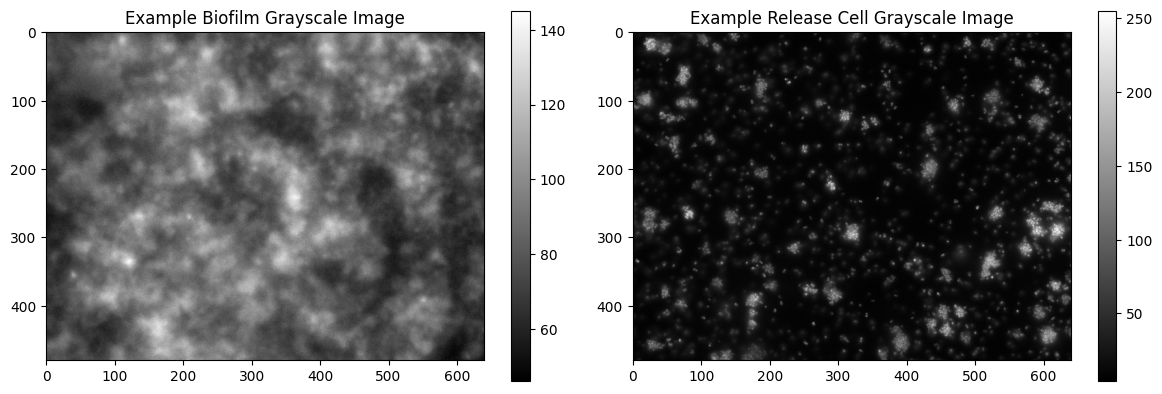

In [34]:
# Convert biofilm images to grayscale by taking green channel
biofilm_gray_images = []
for img in biofilm_raw_images:
    gray_img = img[:,:,1]
    biofilm_gray_images.append(gray_img)

# Convert release cell images to grayscale by taking green channel
release_cell_gray_images = []
for img in release_cell_raw_images:
    gray_img = img[:,:,1]
    release_cell_gray_images.append(gray_img)



# Display example images
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.imshow(biofilm_gray_images[0], cmap='gray')
plt.title('Example Biofilm Grayscale Image')
plt.colorbar()

plt.subplot(122)
plt.imshow(release_cell_gray_images[0], cmap='gray')
plt.title('Example Release Cell Grayscale Image')
plt.colorbar()

plt.tight_layout()
plt.show()




# Create X and y values

### Convert release cell images to pandas dataframes

In [51]:
# Convert each release cell image to a pandas dataframe
release_cell_dfs = []
for img in release_cell_gray_images:
    df = pd.DataFrame(img)
    release_cell_dfs.append(df)

print("Head of first release cell dataframe:")
display(release_cell_dfs[0].head())

Head of first release cell dataframe:


,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,11,9,12,12,12,13,12,13,16,15,...,10,14,19,26,38,40,38,39,31,27
1,12,13,12,13,13,16,16,16,17,19,...,12,14,21,30,39,45,38,32,31,27
2,13,14,14,16,16,16,18,18,19,21,...,12,16,21,28,36,42,40,34,31,26
3,13,15,16,15,17,17,18,18,21,23,...,14,17,24,28,33,35,36,34,30,26
4,13,15,17,18,17,18,20,21,24,24,...,16,18,24,30,38,36,36,33,32,27


### Convert biofilm images to average pixel value

In [47]:
# Calculate average pixel value for each biofilm image
biofilm_y = []
for img in biofilm_gray_images:
    avg_pixel = np.mean(img)
    biofilm_y.append(avg_pixel)

biofilm_y = np.array(biofilm_y)

print(biofilm_y)



[ 83.81711263  92.20647135 132.06198568 145.31101237 108.36349609
  76.91516927]


# Random Forest Model

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

### Format X and y values for Random Forest

In [61]:
X = [df.values.flatten() for df in release_cell_dfs]   # list of 1D arrays
X = np.array(X)                                        # shape (n_samples, 250000)
y = biofilm_y                                          # shape (n_samples,)

### Split into train and test

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Create Random Forest model and train

In [67]:
rf = RandomForestRegressor(
    n_estimators=100, 
    random_state=42,
)

rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = rf.predict(X_test)

# Compute MSE by hand
mse = 0
for y_true, y_predicted in zip(y_test, y_pred):
    mse += (y_true - y_predicted) ** 2
mse = mse / len(y_test)

print("MSE:", mse)

MSE: 1364.1873445243389
